In [1]:
import generate_data
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = generate_data.load_data("data_ising_square_largeL.pkl")

In [3]:
data.keys()

dict_keys([16, 128, 8, 32, 64, 'Ls', 256])

In [4]:
data['Ls']

[8, 16, 32, 64, 128, 256]

In [5]:
data_L_8 = data[8]
data_L_8.keys()
E = data_L_8['E']
obs_keys = data_L_8['observables']
print(obs_keys)

['E', 'C', 'M', 'absM', 'chi', 'UB']


In [6]:
def plot_observable(obs='E'):
    plt.figure()
    for L in data['Ls']:
        data_L = data[L]
        Ts = data_L['Ts']
        E = data_L[obs]
        plt.errorbar(Ts, E[:, 0], E[:, 1], label="L = {L:d}".format(L=L))
    plt.ylabel(obs)
    plt.xlabel("T")
    plt.legend()
    plt.show()

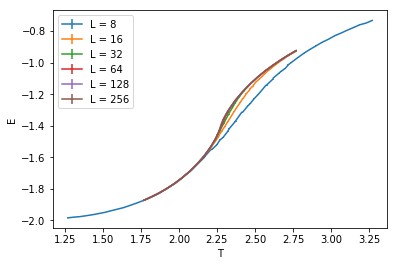

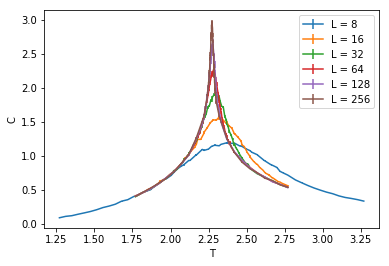

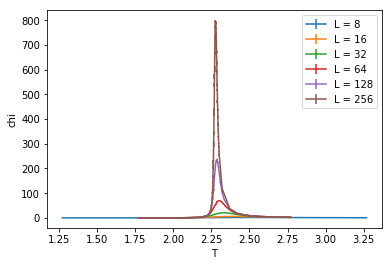

In [7]:
plot_observable('E')
plot_observable('C')
plot_observable('chi')

estimate with np.argmax from chi: T_c ~= 2.26642095644


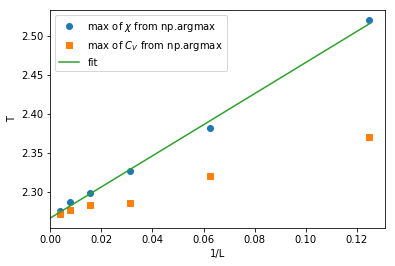

NB: The fit function T_{max} = T_c + const/L is justified a posteriory by the scaling collapse with nu = 1.
In general T_{max} = T_c + const / L^{\nu} + subleading terms.


In [8]:
Ls = np.array(data['Ls'])
T_max_chi = []
T_max_C = []
for L in Ls:
    data_L = data[L]
    Ts = data_L['Ts']
    chi = data_L['chi'][:, 0]
    index_max_chi = np.argmax(chi)
    T_max_chi.append(Ts[index_max_chi])
    C = data_L['C'][:, 0]
    index_max_C = np.argmax(C)
    T_max_C.append(Ts[index_max_C])

plt.figure()
plt.plot(1./Ls, T_max_chi, 'o', label='max of $\\chi$ from np.argmax')
plt.plot(1./Ls, T_max_C, 's', label='max of $C_V$ from np.argmax')

# fit a straight line to the T_max_chi vs 1/L values
fit_coeff = np.polyfit(1./Ls, T_max_chi, 1)
plt.plot([0, 1./8], np.polyval(fit_coeff, [0, 1./8]), label='fit')
print("estimate with np.argmax from chi: T_c ~=", fit_coeff[-1])
Tc = fit_coeff[-1]

plt.xlabel('1/L')
plt.ylabel('T')
plt.xlim(0.)
plt.legend()
plt.show()

print("NB: The fit function T_{max} = T_c + const/L is justified a posteriory by the scaling collapse with nu = 1.")
print("In general T_{max} = T_c + const / L^{\\nu} + subleading terms.")

Since the data is noisy, it is better to extract the maximum by fitting a parabola instead of just using np.argmax.
estimated this way from C: T_c ~= 2.26857759147 , not too bad :)


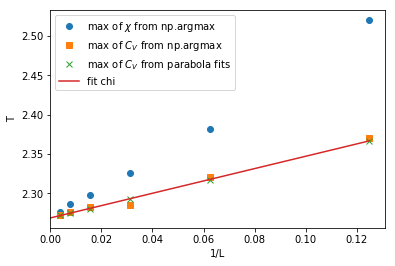

In [9]:
print("Since the data is noisy, it is better to extract the maximum by fitting a parabola instead of just using np.argmax.")
T_max_C_parabola = []
for L in Ls:
    data_L = data[L]
    Ts = data_L['Ts']
    chi = data_L['C'][:, 0]
    index_max_C = np.argmax(C)
    # use 20 values around the guess from argmax
    # (the data set has more points close to Tc )
    Ts_fit_parabola = Ts[index_max_C-10 : index_max_C+10]
    C_fit_parabola = data_L['C'][index_max_C-10 : index_max_C+10]
    fit_coeff_parabola = np.polyfit(Ts_fit_parabola, C_fit_parabola[:, 0], 2)
    # fit_coeff = a , b, c, such that the fit = a T**2 + b T + c
    # -> maxima = -b / 2 a
    T_max_C_parabola.append(-fit_coeff_parabola[1] / 2/fit_coeff_parabola[0])

# replot 
plt.figure()
plt.plot(1./Ls, T_max_chi, 'o', label='max of $\\chi$ from np.argmax')
plt.plot(1./Ls, T_max_C, 's', label='max of $C_V$ from np.argmax')
plt.plot(1./Ls, T_max_C_parabola, 'x', label='max of $C_V$ from parabola fits')

# fit a straight line to the T_max_chi vs 1/L values
fit_coeff_chi = np.polyfit(1./Ls, T_max_C_parabola, 1)
plt.plot([0, 1./8], np.polyval(fit_coeff_chi, [0, 1./8]), label='fit chi')
print("estimated this way from C: T_c ~=", fit_coeff_chi[-1], ", not too bad :)")
Tc = fit_coeff_chi[-1]

plt.xlabel('1/L')
plt.ylabel('T')
plt.xlim(0.)
plt.legend()
plt.show()

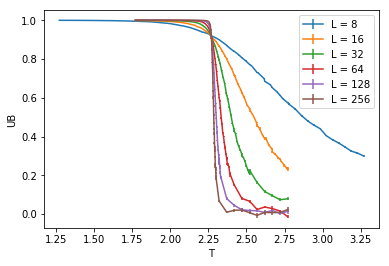

In [10]:
plot_observable('UB')


In [11]:
# extract crossing points
print("NB: again, to extract the crossing points, it's best to fit lines to the data")
lines_fit_coeff = {} # dictionary: L -> fit_coeff
for L in data['Ls']:
    # fit a line to 8 points close to the guess of Tc
    data_L = data[L]
    index_close = np.argmin(np.abs(Ts-Tc))
    Ts_fit = data_L['Ts'][index_close-3 : index_close+5] 
    Ub_fit = data_L['UB'][index_close-3 : index_close+5, 0]
    fit_coeff = np.polyfit(Ts_fit, Ub_fit, 1)
    lines_fit_coeff[L] = fit_coeff

crossings_2L = []
crossings_4L = []
for L in data['Ls']:
    if 2*L in lines_fit_coeff:
        fit_L = lines_fit_coeff[L]
        fit_2L = lines_fit_coeff[2*L]
        diff = fit_L - fit_2L
        crossing = -diff[1]/diff[0]
        print("crossing", L, "with", 2*L, "at T = ", crossing)
        crossings_2L.append(crossing)
    if 4*L in lines_fit_coeff:
        fit_L = lines_fit_coeff[L]
        fit_4L = lines_fit_coeff[4*L]
        diff = fit_L - fit_4L
        crossing = -diff[1]/diff[0]
        print("crossing", L, "with", 4*L, "at T = ", crossing)
        crossings_4L.append(crossing)
print("mean of the crossings L with 2L:", np.mean(crossings_2L))
print("mean of the crossings L with 4L:", np.mean(crossings_4L))
print("For comparison: Tc_exact = ", 2. / np.log(1. + np.sqrt(2)))
Tc = np.mean(crossings_4L)

NB: again, to extract the crossing points, it's best to fit lines to the data
crossing 8 with 16 at T =  2.26038575165
crossing 8 with 32 at T =  2.26478855761
crossing 16 with 32 at T =  2.26727505341
crossing 16 with 64 at T =  2.26829009947
crossing 32 with 64 at T =  2.2687726347
crossing 32 with 128 at T =  2.26861142587
crossing 64 with 128 at T =  2.26853700143
crossing 64 with 256 at T =  2.26888894982
crossing 128 with 256 at T =  2.26905657814
mean of the crossings L with 2L: 2.26680540387
mean of the crossings L with 4L: 2.26764475819
For comparison: Tc_exact =  2.26918531421


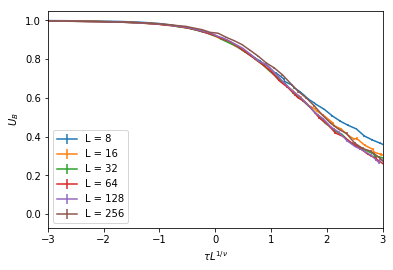

NB: The scaling collapse is only expected near the critical point.
Do not look at all the data, but zoom in to values close to tau = 0 (e.g. here -3:3 on the x-axis!)


In [12]:
# data collapse of UB
nu = 1.0

plt.figure()
for L in data['Ls']:
    data_L = data[L]
    Ts = data_L['Ts']
    UB = data_L['UB']
    tau = (Ts -Tc)/Tc
    tau_scaled = tau * L**(1./nu)
    plt.errorbar(tau_scaled, UB[:, 0], UB[:, 1], label="L = {L:d}".format(L=L))
plt.ylabel("$U_B$")
plt.xlabel("$\\tau  L^{1/\\nu}$")
plt.xlim(-3, 3)
plt.legend()
plt.show()

print("NB: The scaling collapse is only expected near the critical point.")
print("Do not look at all the data, but zoom in to values close to tau = 0 (e.g. here -3:3 on the x-axis!)")

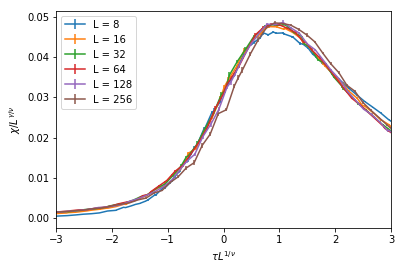

In [13]:
# data collapse of chi
gamma = 1.75

plt.figure()
for L in data['Ls']:
    data_L = data[L]
    Ts = data_L['Ts']
    chi = data_L['chi']
    tau = (Ts -Tc)/Tc
    tau_scaled = tau * L**(1./nu)
    chi_scaled = chi / L**(gamma / nu)
    plt.errorbar(tau_scaled, chi_scaled[:, 0], chi_scaled[:, 1], label="L = {L:d}".format(L=L))
plt.ylabel("$\\chi / L^{\\gamma/\\nu}$")
plt.xlabel("$\\tau  L^{1/\\nu}$")
plt.xlim(-3, 3)
plt.legend()
plt.show()
    

NB: since nu = 1, we formally get alpha = 0 from the relation d * nu= 2 - alpha.
Hence, C does not scale with a powerlaw, but with log(L)
Still, the collapse is worse, since subleading terms are more important...


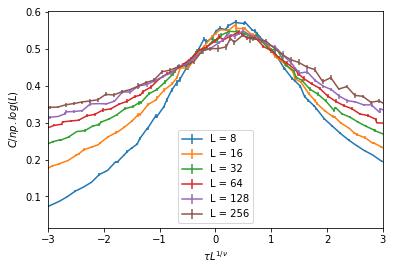

In [14]:
# data collapse of C
print("NB: since nu = 1, we formally get alpha = 0 from the relation d * nu= 2 - alpha.")
print("Hence, C does not scale with a powerlaw, but with log(L)")
print("Still, the collapse is worse, since subleading terms are more important...")

plt.figure()
for L in data['Ls']:
    data_L = data[L]
    Ts = data_L['Ts']
    C = data_L['C']
    tau = (Ts -Tc)/Tc
    tau_scaled = tau * L**(1./nu)
    C_scaled = C / np.log(L)
    plt.errorbar(tau_scaled, C_scaled[:, 0], C_scaled[:, 1], label="L = {L:d}".format(L=L))
plt.ylabel("$C /np.log(L)$")
plt.xlabel("$\\tau  L^{1/\\nu}$")
plt.xlim(-3, 3)
plt.legend()
plt.show()
    

In [15]:
msg = """
For the triangular lattice, you just need to add the lines 
            m3 = xy_to_n((x+1) % Lx, (y+1) % Ly)
            bonds.append([n, m3])
to the function `init_system` in the file generate_data.py.
The critical temperature is different (Tc~= 3.65), but the critical exponents are still the same!
"""
print(msg)


For the triangular lattice, you just need to add the lines 
            m3 = xy_to_n((x+1) % Lx, (y+1) % Ly)
            bonds.append([n, m3])
to the function `init_system` in the file generate_data.py.
The critical temperature is different (Tc~= 3.65), but the critical exponents are still the same!

